# Testing Analysis Class (2023-07-12)

Purpose:
Cleaning analysis of June 15th 2022 data for export, doing some plots to check the results.  

## Setting up Analysis Environment
* Importing libraries and functions
* Creating results, figures, folders
* Importing the data and storing it within data folder

In [2]:
from os import sys
import os
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px

import main
import propellers
import motors
from aircraft import airplane
import cl_finders

# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

In [3]:
### Definining name of analysis ###
name = '2023-07-12_PolarResults_2022-06-15'
data_path = '../data/'
data_folder = 'createv-2022-06-15'
file_name = 'june15_2022.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [4]:
### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

## Importing Data
### Importing new dataset

In [5]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

### Importing Old AIAA Dataset Used to Compare

In [6]:
df_old = pd.read_pickle("../data/createv-2022-06-15/june15_2022_100Hz.pkl")
df_old = df_old.interpolate(method="linear")

## Comparing Dataframes

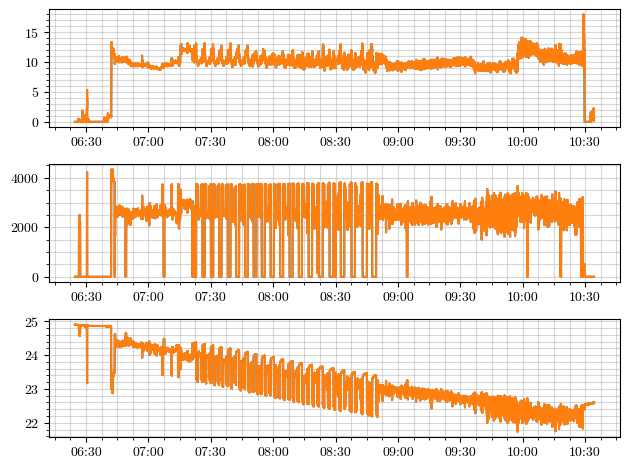

In [7]:
plt.figure()
ax0 = plt.subplot(3,1,1)
ax1 = plt.subplot(3,1,2, sharex=ax0)
ax2 = plt.subplot(3,1,3, sharex=ax0)

ax0.plot(df.index, df.Airspeed_Sensor0, marker='')
ax0.plot(df_old.index, df_old.Airspeed_Sensor0, marker='')

ax1.plot(df.index, df.MotorRPM, marker='')
ax1.plot(df_old.index, df_old.MotorRPM, marker='')

ax2.plot(df.index, df.EscVoltage, marker='')
ax2.plot(df_old.index, df_old.EscVoltage, marker='')

## Defining Vehicle

In [8]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 18.5 x 12 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

highorderpolar = True

## Masking Data (Based on Time Series Data)

In [9]:
### New Mask Initialization ###

year = 2022
month = 6
day = 15

# Cruise Masking
cruise_seg_times = np.array([['08:54:36','09:04:09'],
                            ['09:04:36','09:16:09'],
                            ['09:16:11','09:26:10'],
                            ['09:26:10','09:36:09'],
                            ['09:57:40','10:02:04'],
                            ['10:02:14','10:07:21'],
                            ['10:07:29','10:17:21'],
                            ['10:18:25','10:24:34'],
                            ['10:25:52','10:27:55']])

desc_seg_times = np.array([['07:22:05','07:22:53'],
                            ['07:26:03','07:27:00'],
                            ['07:30:07','07:31:07'],
                            ['07:34:02','07:35:07'],
                            ['07:38:15','07:39:23'],
                            ['07:42:09','07:43:33'],
                            ['07:46:31','07:47:44'],
                            ['07:50:35','07:51:52'],
                            ['07:54:31','07:55:52'],
                            ['07:58:44','08:00:17'],
                            ['08:03:18','08:04:43'],
                            ['08:07:50','08:09:15'],
                            ['08:12:18','08:13:46'],
                            ['08:17:13','08:18:37'],
                            ['08:22:27','08:23:45'],
                            ['08:27:36','08:28:54'],
                            ['08:33:13','08:34:06'],
                            ['08:38:18','08:39:14'],
                            ['08:43:38','08:44:59'],
                            ['08:48:03','08:49:26']])
cruise_masks = cl_finders.get_maskarray(df, cruise_seg_times, year, month, day)
desc_masks = cl_finders.get_maskarray(df, desc_seg_times, year, month, day)

## Time Indexed Analysis
### Intermediate variables
### Power Required Estimation
### Reduction to $C_L$, $C_D$

In [10]:
class data():
    def __init__(self, prop, motor, aircraft):
        self.prop = prop
        self.motor = motor
        self.aircraft = aircraft
        return
    def add_cruise(self, df):
        # Attitude 
        self.phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
        self.pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

        # Inertial Measurement Unit
        self.U_dot = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction

        # Atmospheric adjustments:
        self.rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
        self.v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
        self.v_tas = self.v_eas * np.sqrt(1.225) * np.sqrt(self.rho)**-1   # the true airspeed
        self.q = 0.5 * self.rho * self.v_tas**2                            # Dynamic pressure 

        # For Descent method
        self.h = df["Altitude_POS"].to_numpy()                   # Altitude
        self.Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
        self.Vd_tas = self.Vd_eas * np.sqrt(1.225) * np.sqrt(self.rho)**-1   # the true airspeed

        # Ground speed limiter
        self.v_dem = df["Airspeed_Demanded"].to_numpy()

        # Propulsion characterization
        self.n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
        self.i_esc = df["EscCurrent"].to_numpy()
        self.v_esc = df["EscVoltage"].to_numpy()
        self.J = self.v_tas / (self.n * prop.diameter)
        self.eff = prop.efficiency(self.J) * motor.efficiency(self.n, self.i_esc)

        # Estimated propulsive power (New Fitting)
        self.P_eta = cl_finders.eta_steady(self.prop, self.motor, self.v_tas, self.n, self.i_esc, self.v_esc)
        self.P_ct = cl_finders.thrust_steady(self.prop, self.rho, self.v_tas, self.n)

        # Getting drag coefficient
        self.Cd_eta = cl_finders.preq2cd(self.aircraft, self.v_tas, self.q, self.P_eta)
        self.Cd_ct = cl_finders.preq2cd(self.aircraft, self.v_tas, self.q, self.P_ct)

        # Getting lift coefficient
        self.CL = cl_finders.cl_banked(self.aircraft, self.q, self.phi)
        return
    
    def add_descent(self, df):

        # Attitude 
        self.phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
        self.pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

        # Inertial Measurement Unit
        self.U_dot = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction

        # Atmospheric adjustments:
        self.rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
        self.v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
        self.v_tas = self.v_eas * np.sqrt(1.225) * np.sqrt(self.rho)**-1   # the true airspeed
        self.q = 0.5 * self.rho * self.v_tas**2                            # Dynamic pressure 

        # For Descent method
        self.h = df["Altitude_POS"].to_numpy()                   # Altitude
        self.Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
        self.Vd_tas = self.Vd_eas * np.sqrt(1.225) * np.sqrt(self.rho)**-1   # the true airspeed

        # Ground speed limiter
        self.v_dem = df["Airspeed_Demanded"].to_numpy()

        # Propulsion characterization
        self.n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
        self.i_esc = df["EscCurrent"].to_numpy()
        self.v_esc = df["EscVoltage"].to_numpy()
        self.J = self.v_tas / (self.n * prop.diameter)

        self.P_desc = cl_finders.desc2preq(self.aircraft, self.prop, self.rho, self.v_tas, self.n, self.q, self.Vd_tas)

        P_desc_acc = cl_finders.descU2preq(createv, prop, rho, v_tas, n, q, Vd_tas, pitch, U_dot)
        P_hybrid = cl_finders.cruise_highorder(createv, prop, rho, v_tas, Vd_tas, n, pitch, U_dot)

        # Getting drag coefficient
        Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
        Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
        Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)
        Cd_desc_acc = cl_finders.preq2cd(createv, v_tas, q, P_desc_acc)

        Cd_hybrid = cl_finders.preq2cd(createv, v_tas, q, P_hybrid)

        # Getting lift coefficient
        CL = cl_finders.cl_banked(createv, q, phi)

In [11]:
cruise_data_new = data(prop, motor, createv)
cruise_data_new.add_cruise(df)

cruise_data_old = data(prop, motor, createv)
cruise_data_old.add_cruise(df_old)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/1727546252.py:16: RuntimeWarning: invalid value encountered in reciprocal
  self.rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/1727546252.py:18: RuntimeWarning: invalid value encountered in reciprocal
  self.v_tas = self.v_eas * np.sqrt(1.225) * np.sqrt(self.rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/1727546252.py:24: RuntimeWarning: invalid value encountered in reciprocal
  self.Vd_tas = self.Vd_eas * np.sqrt(1.225) * np.sqrt(self.rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/1727546252.py:33: RuntimeWarning: divide by zero encountered in true_divide
  self.J = self.v_tas / (self.n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1497704 but corresponding boolean dimension is 1497703

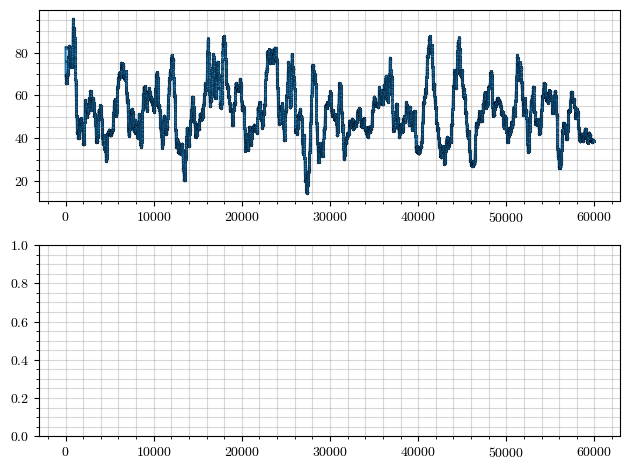

In [12]:
plt.figure()
ax0 = plt.subplot(2,1,1)
ax1 = plt.subplot(2,1,2, sharex=ax0)
ax0.plot(cruise_data_new.P_eta[cruise_masks[2]])
ax0.plot(cruise_data_old.P_eta[cruise_masks[2]])
ax1.plot(cruise_data_old.n[cruise_masks[2]])
ax1.plot(cruise_data_new.n[cruise_masks[2]])
plt.show()


Comparison fixed by setting the propeller to the 18.5 x 12!

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/2126081776.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/2126081776.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/2126081776.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/2126081776.py:28: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_9403/2126081776.py:28: Run

Freewheel thrust coefficient:  -0.00804445463199624 
 Advance Ratio:  0.8386905840958647 
 CP Freewheel:  5.129680916149404e-10


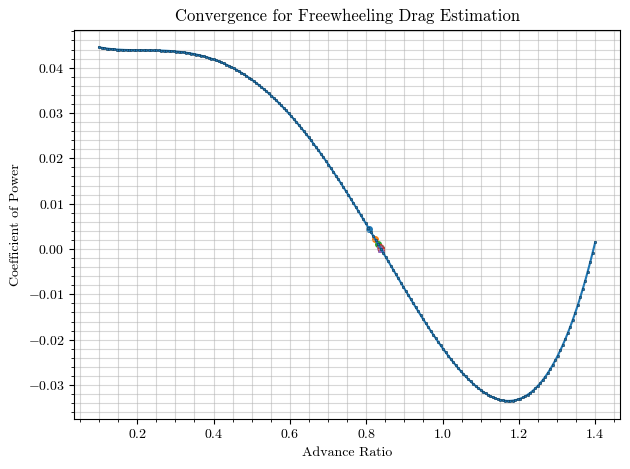

Propeller Drag[nan nan nan ...  0.  0.  0.]
Freewheel thrust coefficient:  -0.00804445463199624 
 Advance Ratio:  0.8386905840958647 
 CP Freewheel:  5.129680916149404e-10


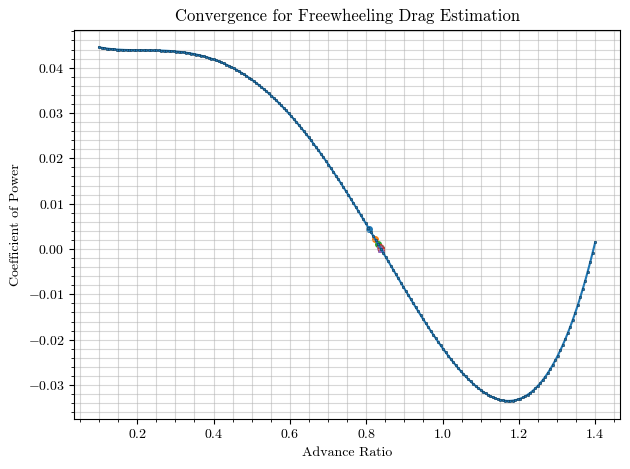

Propeller Drag[nan nan nan ...  0.  0.  0.]


/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:173: RuntimeWarning: invalid value encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1


In [13]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

P_desc_acc = cl_finders.descU2preq(createv, prop, rho, v_tas, n, q, Vd_tas, pitch, U_dot)
P_hybrid = cl_finders.cruise_highorder(createv, prop, rho, v_tas, Vd_tas, n, pitch, U_dot)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)
Cd_desc_acc = cl_finders.preq2cd(createv, v_tas, q, P_desc_acc)

Cd_hybrid = cl_finders.preq2cd(createv, v_tas, q, P_hybrid)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

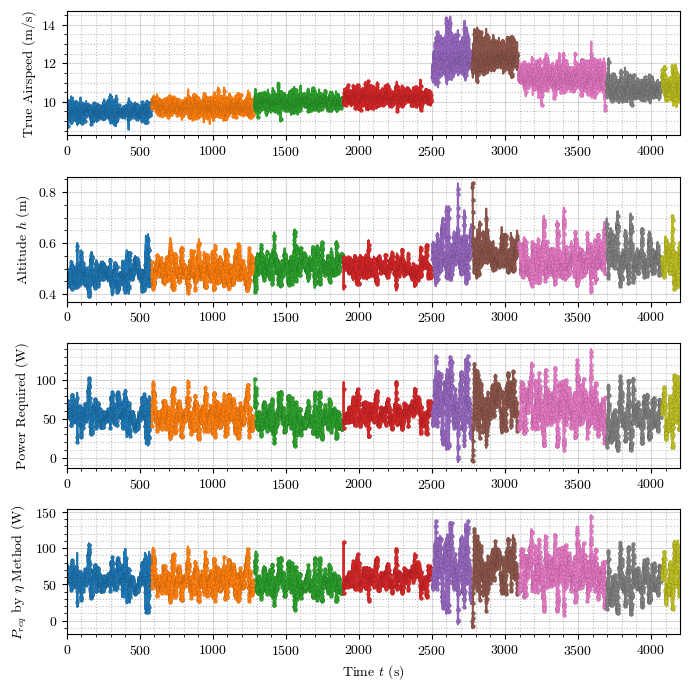

In [14]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(cruise_masks)):
    time_s = np.linspace(t_init, (len(v_tas[cruise_masks[i]])-1)/100 + t_init, len(v_tas[cruise_masks[i]]))
    ax1.plot(time_s, v_tas[cruise_masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(cruise_masks)):
    time_s = np.linspace(t_init, (len(v_tas[cruise_masks[i]])-1)/100 + t_init, len(v_tas[cruise_masks[i]]))
    ax0.plot(time_s, J[cruise_masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(cruise_masks)):
    time_s = np.linspace(t_init, (len(v_tas[cruise_masks[i]])-1)/100 + t_init, len(v_tas[cruise_masks[i]]))
    ax2.plot(time_s, P_ct[cruise_masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(cruise_masks)):
    time_s = np.linspace(t_init, (len(v_tas[cruise_masks[i]])-1)/100 + t_init, len(v_tas[cruise_masks[i]]))
    ax3.plot(time_s, P_eta[cruise_masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$P_{req}$ by $\eta$ Method (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()
# plt.savefig("Figures/cruise_overview_pres.pdf", bbox_inches='tight')

## Collecting $C_L$, $C_D$

In [15]:
# Totalling up CL, CD for Cruise
cl_total_cruise = cl_finders.total_segments_boolean(CL, cruise_masks)
cd_total_eta = cl_finders.total_segments_boolean(Cd_eta, cruise_masks)
cd_total_ct = cl_finders.total_segments_boolean(Cd_ct, cruise_masks)

# Totalling up CL, CD for Descents
cl_total_desc = cl_finders.total_segments_boolean(CL, desc_masks)
cd_total_desc = cl_finders.total_segments_boolean(Cd_desc, desc_masks)

## Forming Manual Segment Averages and Getting Stats

In [16]:
[cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta] = cl_finders.collect_segments(cruise_masks, CL, Cd_eta)
[cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct] = cl_finders.collect_segments(cruise_masks, CL, Cd_ct)
[cl_means_desc, cl_stds_desc, cl_ci95s_desc, cd_means_desc, cd_stds_desc, cd_ci95s_desc] = cl_finders.collect_segments(desc_masks, CL, Cd_desc)

## Forming Automatic Binned Averages and Getting Stats

In [17]:
bins = np.linspace(0.05, 1.4, 51)

[cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_eta)
[cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_ct)
[cl_means_desc_bin, cl_stds_desc_bin, cl_ci95s_desc_bin, cd_means_desc_bin, cd_stds_desc_bin, cd_ci95s_desc_bin] = cl_finders.collect_bins(bins, cl_total_desc, cd_total_desc)

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:391: RuntimeWarning: Mean of empty slice.
  cl_means = [total_lift_coeffs[digitized == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods

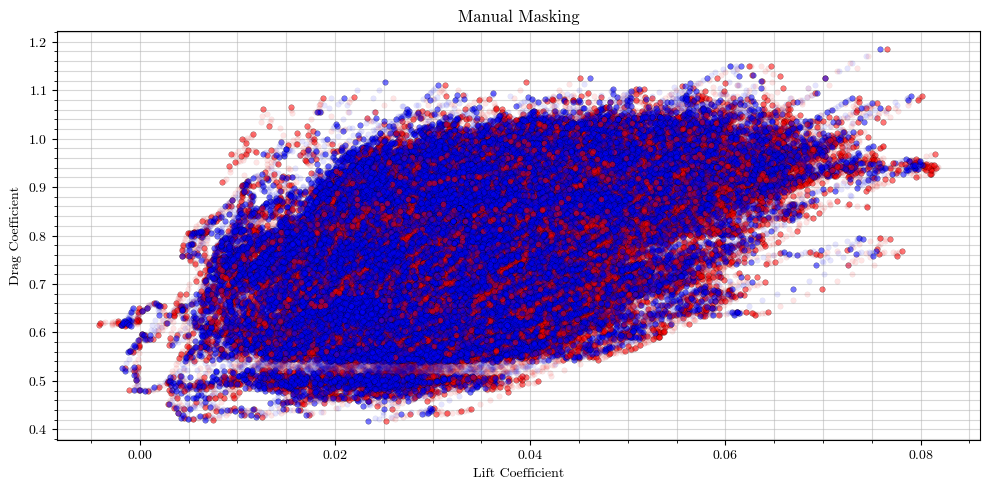

In [18]:
# Plot with static masking
plt.figure(figsize=(10,5))
plt.title("Manual Masking")

for i in range(len(cruise_masks)):
    plt.plot(Cd_eta[cruise_masks[i]], CL[cruise_masks[i]], linestyle='', marker='o', markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0], alpha=0.1)
    plt.plot(Cd_ct[cruise_masks[i]], CL[cruise_masks[i]], linestyle='', marker='o', markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0], alpha=0.1)
    
plt.grid(True)
plt.xlabel("Lift Coefficient")
plt.ylabel("Drag Coefficient")
plt.show()

In [19]:
# Need to get rid of NaN'
print(cd_means_ct)
# Fixed it!

[0.04515375 0.04112083 0.03547019 0.03737906 0.02725545 0.02567695
 0.03117267 0.02855304 0.03352134]


## Performing Curve Fitting on Manual Segments

In [20]:
# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, cd_means_eta, cl_means_eta,highorder=highorderpolar)
polar_ct = cl_finders.cd2polar(createv, cd_means_ct, cl_means_ct, highorder=highorderpolar)
polar_desc = cl_finders.cd2polar(createv, cd_means_desc, cl_means_desc, highorder=highorderpolar)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (8,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (8,14))
Peq_desc, EAS = cl_finders.polar2preqew(createv, polar_desc, (8,14))

## Performing Curve Fitting on Binned Results

In [21]:
# Finding drag polar:
polar_eta_bin = cl_finders.cd2polar(createv, cd_means_eta_bin, cl_means_eta_bin,highorder=highorderpolar)
polar_ct_bin = cl_finders.cd2polar(createv, cd_means_ct_bin, cl_means_ct_bin, highorder=highorderpolar)
polar_desc_bin = cl_finders.cd2polar(createv, cd_means_desc_bin, cl_means_desc_bin, highorder=highorderpolar)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta_bin, EAS_bin = cl_finders.polar2preqew(createv, polar_eta_bin, (8,14))
Peq_ct_bin, EAS_bin = cl_finders.polar2preqew(createv, polar_ct_bin, (8,14))
Peq_desc_bin, EAS_bin = cl_finders.polar2preqew(createv, polar_desc_bin, (8,14))

## Packing Results

In [22]:
eta_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_total_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta, polar_eta, createv)
ct_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_total_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct, polar_ct, createv)

descent_segresult = cl_finders.packaging_binresults(cl_total_desc, cl_means_desc, cl_stds_desc, cl_ci95s_desc, cd_total_desc, cd_means_desc, cd_stds_desc, cd_ci95s_desc, polar_desc, createv)

In [23]:
eta_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_total_eta, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin, polar_eta_bin, createv)
ct_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_total_ct, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin, polar_ct_bin, createv)

descent_binresult = cl_finders.packaging_binresults(cl_total_desc, cl_means_desc_bin, cl_stds_desc_bin, cl_ci95s_desc_bin, cd_total_desc, cd_means_desc_bin, cd_stds_desc_bin, cd_ci95s_desc_bin, polar_desc_bin, createv)

## Saving Results

In [24]:
# Saving results to their pickles
pd.to_pickle(eta_cruise_segresult, result_path+'eta_cruise_segresult.pkl')
pd.to_pickle(ct_cruise_segresult, result_path+'ct_cruise_segresult.pkl')
pd.to_pickle(descent_segresult, result_path+'descent_segresult.pkl')

pd.to_pickle(eta_cruise_binresult, result_path+'eta_cruise_binresult.pkl')
pd.to_pickle(ct_cruise_binresult, result_path+'ct_cruise_binresult.pkl')
pd.to_pickle(descent_binresult, result_path+'descent_binresult.pkl')

## Checking the Fitting Results

In [25]:
print(eta_cruise_binresult.fit_polar)
print(eta_cruise_segresult.fit_polar)

print(ct_cruise_binresult.fit_polar)
print(ct_cruise_segresult.fit_polar)

[0.01717623 0.36695202 0.22225551]
[0.0278625  0.22370965 0.51656652]
[0.01630308 0.36075351 0.23286301]
[0.0261833  0.24458002 0.49062592]


In [26]:
polar_ct_lo = cl_finders.cd2polar(createv, cd_means_ct, cl_means_ct, highorder=False)
print(polar_ct_lo)

[0.01606629 0.68264988]


In [27]:
# Importing Acceleration Datapoints
acc_result = pd.read_pickle('../Results/2023-07-06_CREATeVTuningAccelerations/acceleration_binresult.pkl')

## Generating Plots of All Results

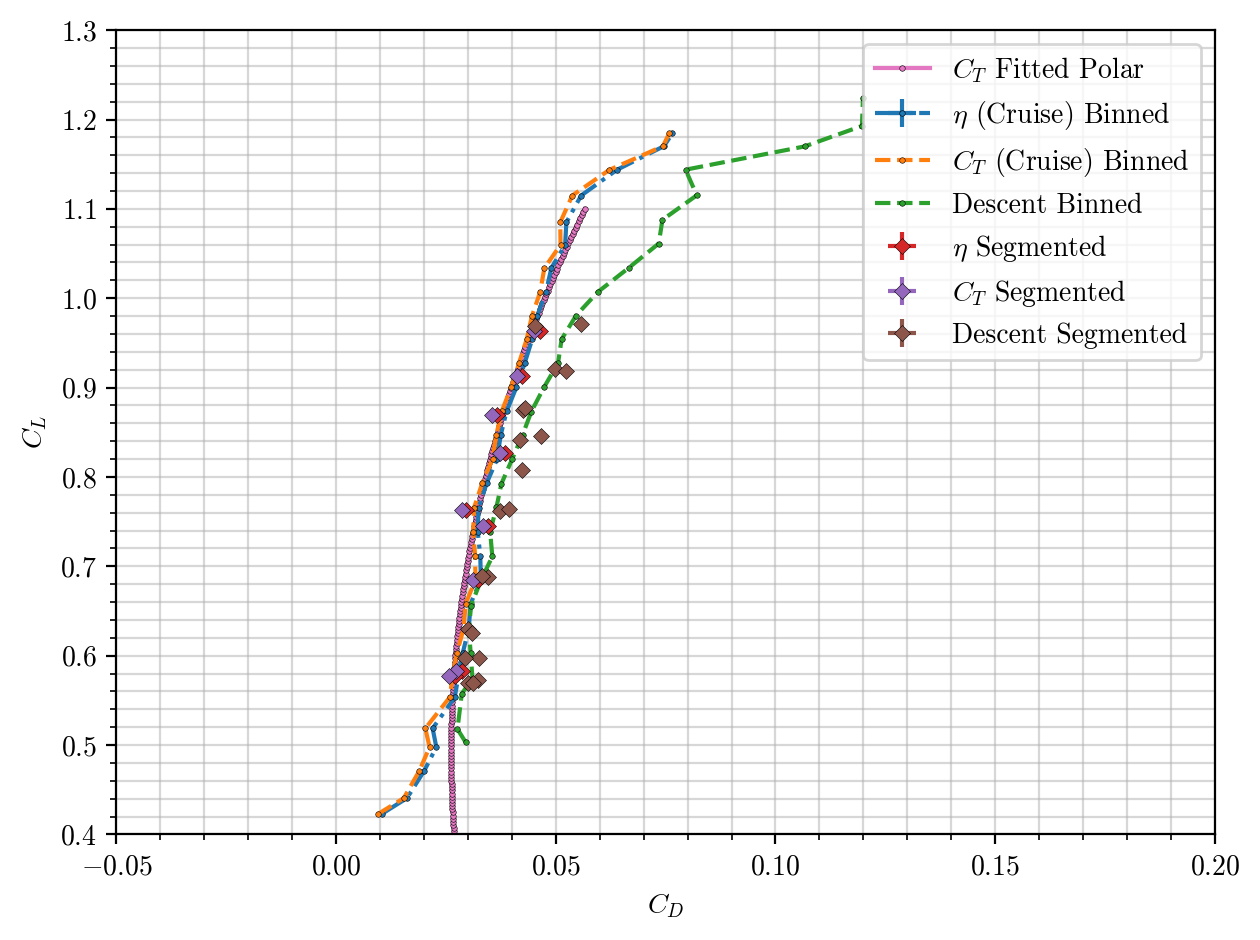

In [28]:
plt.figure(dpi=200)
# plt.plot(eta_cruise_binresult.raw_polar.CD, eta_cruise_binresult.raw_polar.CL, marker='.', markersize=1, linestyle='', alpha=0.1, label='Cruise Raw')
# plt.plot(descent_binresult.raw_polar.CD, descent_binresult.raw_polar.CL, marker='.', markersize=1, linestyle='', alpha=0.1, label='Descent Raw')
plt.errorbar(eta_cruise_binresult.ave_polar.CD, eta_cruise_binresult.ave_polar.CL, xerr=eta_cruise_binresult.ci95_polar.CD, yerr=eta_cruise_binresult.ci95_polar.CL, linestyle='-.', label='$\eta$ (Cruise) Binned')
plt.errorbar(ct_cruise_binresult.ave_polar.CD, ct_cruise_binresult.ave_polar.CL, linestyle='--', label='$C_T$ (Cruise) Binned')
plt.errorbar(descent_binresult.ave_polar.CD, descent_binresult.ave_polar.CL, linestyle='--', label='Descent Binned')

plt.errorbar(eta_cruise_segresult.ave_polar.CD, eta_cruise_segresult.ave_polar.CL, xerr=eta_cruise_segresult.ci95_polar.CD, yerr=eta_cruise_segresult.ci95_polar.CL, linestyle='', marker='D', label='$\eta$ Segmented')
plt.errorbar(ct_cruise_segresult.ave_polar.CD, ct_cruise_segresult.ave_polar.CL, xerr=ct_cruise_segresult.ci95_polar.CD, yerr=ct_cruise_segresult.ci95_polar.CL, linestyle='', marker='D', label='$C_T$ Segmented')
plt.errorbar(descent_segresult.ave_polar.CD, descent_segresult.ave_polar.CL, xerr=descent_segresult.ci95_polar.CD, yerr=descent_segresult.ci95_polar.CL, linestyle='', marker='D', label='Descent Segmented')

# CL_fit, CD_fit = cl_finders.plotfittedpolar(createv, polar_ct_lo, (0.4, 1.1))
# plt.plot(CD_fit, CL_fit)
CL_fit, CD_fit = cl_finders.plotfittedpolar(createv, polar_ct, (0.4, 1.1))
plt.plot(CD_fit, CL_fit, label='$C_T$ Fitted Polar')


plt.xlim([-0.05, 0.2])
plt.ylim([0.4, 1.3])
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.legend()
plt.show()

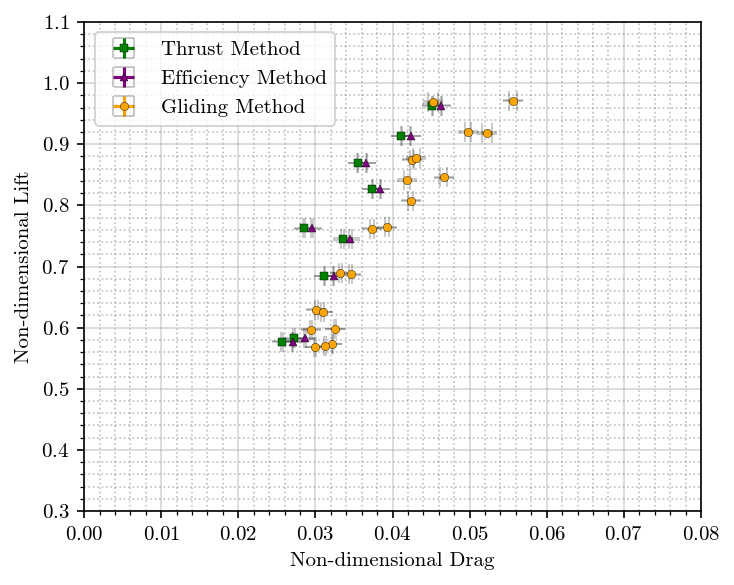

In [32]:
# Drag Polar plots #
plt.figure(figsize=(5,4), dpi=150)
plt.errorbar(cd_means_ct, cl_means_ct, xerr=cd_ci95s_ct, yerr=cl_ci95s_ct, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(cd_means_eta, cl_means_eta, xerr=cd_ci95s_eta, yerr=cl_ci95s_eta, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])
plt.errorbar(cd_means_desc, cl_means_desc, xerr=cd_ci95s_desc, yerr=cl_ci95s_desc, capsize=5, fmt='o', color='orange', label = "Gliding Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.xlim([0, 0.08])
plt.ylim([0.3, 1.1])
plt.tight_layout
plt.show()